In [3]:
#kaggle预测房价
import hashlib
import os 
import tarfile
import zipfile
import requests
DATA_HUB=dict()
DATA_URL="http://d2l-data.s3-accelerate.amazonaws.com/"
def download(name,cache_dir=os.path.join("..",'data')):
    assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}"
    url,shal_hash=DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname=os.path.join(cache_dir,url.split('/')[-1])
    if os.path.exists(fname):
        sha1=hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data=f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest()==shal_hash:
            return fname
    print(f"正在从{url}下载{fname}...")
    r=requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname
def download_extract(name,folder=None):
    fname=download(name)
    base_dir=os.path.dirname(fname)
    data_dir,ext=os.path.splitext(fname)
    if ext=='.zip':
        fp=zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','gz'):
        fp=tarfile.open(fname,'r')
    else:
        assert False,"只有zip/tar文件可以被解压缩"
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

def download_all():
    for name in DATA_HUB:
        download(name)

In [20]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
DATA_HUB["kaggle_house_train"]=(DATA_URL+"kaggle_house_pred_train.csv","585e9cc93e70b39160e7921475f9bcd7d31219ce")
DATA_HUB["kaggle_house_test"]=(DATA_URL+"kaggle_house_pred_test.csv","fa19780a7b011d9b009e8bff8e99922a8ee2eb90")
train_data=pd.read_csv(download("kaggle_house_train"))
test_data=pd.read_csv(download("kaggle_house_test"))
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [21]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [22]:
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features]=all_features[numeric_features].apply(
lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [23]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 330)

In [61]:
n_train=train_data.shape[0]
n_train
train_features=torch.from_numpy(all_features[:n_train].values.astype(np.float32))
test_features=torch.from_numpy(all_features[n_train:].values.astype(np.float32))
train_labels=torch.from_numpy(train_data.SalePrice.values.reshape(-1,1).astype(np.float32))

In [62]:
loss=nn.MSELoss()
in_features=train_features.shape[1]
def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    return net

In [92]:
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float("inf"))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
#   print(num_epochs)
    train_ls,test_ls=[],[]
    train_iter=d2l.load_array((train_features,train_labels),batch_size)
    optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l=loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=torch.cat([X_train,X_part],0)
            y_train=torch.cat([y_train,y_part],0)
    return X_train,y_train,X_valid,y_valid

def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i ==0:
            print(list(range(1,num_epochs+1)))
            print(len(train_ls))
            print(len(valid_ls))
            d2l.plot(np.array(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',
                     xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
        print(f"折{i+1},训练log rmse{float(train_ls[-1]):f},",f"验证log rmse{float(valid_ls[-1]):f}")
    return train_l_sum/k,valid_l_sum/k

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
100
100
折1,训练log rmse0.170237, 验证log rmse0.157041
折2,训练log rmse0.162176, 验证log rmse0.190130
折3,训练log rmse0.163989, 验证log rmse0.168687
折4,训练log rmse0.168221, 验证log rmse0.154860
折5,训练log rmse0.163523, 验证log rmse0.183124
5-折验证：平均训练log rmse0.165629, 平均验证log rmse：0.170769


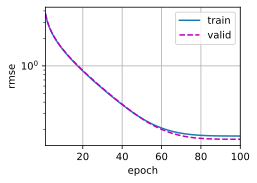

In [93]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f"{k}-折验证：平均训练log rmse{float(train_l):f},",f"平均验证log rmse：{float(valid_l):f}")

训练log rmse：0.162560


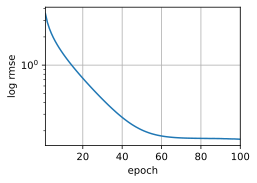

In [94]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net= get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
    print(f"训练log rmse：{float(train_ls[-1]):f}")
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    subminssion=pd.concat([test_data['Id'],test_data["SalePrice"]],axis=1)
    subminssion.to_csv("submission.csv",index=False)

train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)
